# Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [2]:
# Load data 
data = pd.read_csv('data.csv')
returns = data

In [3]:
# Calculate mean and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.0475  

In [4]:
# Define the portfolio performance metrics
def portfolio_metrics(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

In [5]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    portfolio_return, portfolio_std = portfolio_metrics(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

In [6]:
# Constraints and bounds
num_assets = len(mean_returns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
bounds = tuple((-1, 1) for _ in range(num_assets))  # Allow shorting but no more than 100%

In [7]:
# Initial weights
initial_weights = num_assets * [1.0 / num_assets]  

# Optimization
result = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

In [8]:
# Extract the optimal weights and Sharpe Ratio
optimal_weights = result.x
optimal_return, optimal_std = portfolio_metrics(optimal_weights, mean_returns, cov_matrix)
max_sharpe_ratio = (optimal_return - rf) / optimal_std

In [9]:
# Output results
print("Optimal Weights:", optimal_weights)
print("Portfolio Return:", optimal_return)
print("Portfolio Standard Deviation:", optimal_std)
print("Maximum Sharpe Ratio:", max_sharpe_ratio)

Optimal Weights: [ 0.15202905 -0.13302031  0.98099126]
Portfolio Return: 0.1820589576129143
Portfolio Standard Deviation: 0.3910053146991314
Maximum Sharpe Ratio: 0.34413587885999447


# Part 2

In [10]:
def calculate_ES(x, alpha=0.025):
    xs = np.sort(x)  
    n = alpha * len(xs)  
    iup = int(np.ceil(n)) 
    idn = int(np.floor(n))   
    ES = np.mean(xs[:idn]) 
    return -ES

In [11]:
def negative_risk_adjusted_return(weights, mean_returns, cov_matrix, rf, returns, alpha=0.025):
    portfolio_return, _ = portfolio_metrics(weights, mean_returns, cov_matrix)
    portfolio_returns = np.dot(returns, weights)
    adjusted_returns = portfolio_returns - rf
    es = calculate_ES(adjusted_returns, alpha)
    rr_p = (portfolio_return - rf) / es
    return -rr_p  

In [12]:
# Optimization
result = minimize(
    negative_risk_adjusted_return,
    initial_weights,
    args=(mean_returns, cov_matrix, rf, returns),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

In [13]:
# Extract the optimal weights and RR_p
optimal_weights_rrp = result.x
optimal_return_rrp, optimal_std_rrp = portfolio_metrics(optimal_weights_rrp, mean_returns, cov_matrix)
portfolio_returns = np.dot(returns, optimal_weights_rrp)
adjusted_returns = portfolio_returns - rf
es_rrp = calculate_ES(adjusted_returns)
max_rrp = (optimal_return_rrp - rf) / es_rrp

In [14]:
# Output results
print("Optimal Weights (RR_p):", optimal_weights_rrp)
print("Portfolio Return (RR_p):", optimal_return_rrp)
print("Portfolio Standard Deviation (RR_p):", optimal_std_rrp)
print("Expected Shortfall (RR_p):", es_rrp)
print("Maximum Risk-Adjusted Return (RR_p):", max_rrp)

Optimal Weights (RR_p): [0.46206864 0.03502933 0.50290203]
Portfolio Return (RR_p): 0.18815914635831188
Portfolio Standard Deviation (RR_p): 0.5698179503518336
Expected Shortfall (RR_p): 0.5311796878771226
Maximum Risk-Adjusted Return (RR_p): 0.26480520541073566


# Part 3

In [15]:
# Tabulate Results
comparison_table = pd.DataFrame({
    "Portfolio": ["Maximum Sharpe Ratio", "Maximum Risk-Adjusted Return"],
    "Weights": [optimal_weights, optimal_weights_rrp],
    "Return": [optimal_return, optimal_return_rrp],
    "Standard Deviation": [optimal_std, optimal_std_rrp],
    "Sharpe Ratio": [max_sharpe_ratio, None],
    "Risk-Adjusted Return": [None, max_rrp],
    "Expected Shortfall (RR_p)": [None, es_rrp]
})

print("Portfolio Comparison Table:")
print(comparison_table)

Portfolio Comparison Table:
                      Portfolio  \
0          Maximum Sharpe Ratio   
1  Maximum Risk-Adjusted Return   

                                             Weights    Return  \
0  [0.1520290521472676, -0.13302030736988432, 0.9...  0.182059   
1  [0.4620686430452974, 0.03502933044279534, 0.50...  0.188159   

   Standard Deviation  Sharpe Ratio  Risk-Adjusted Return  \
0            0.391005      0.344136                   NaN   
1            0.569818           NaN              0.264805   

   Expected Shortfall (RR_p)  
0                        NaN  
1                    0.53118  


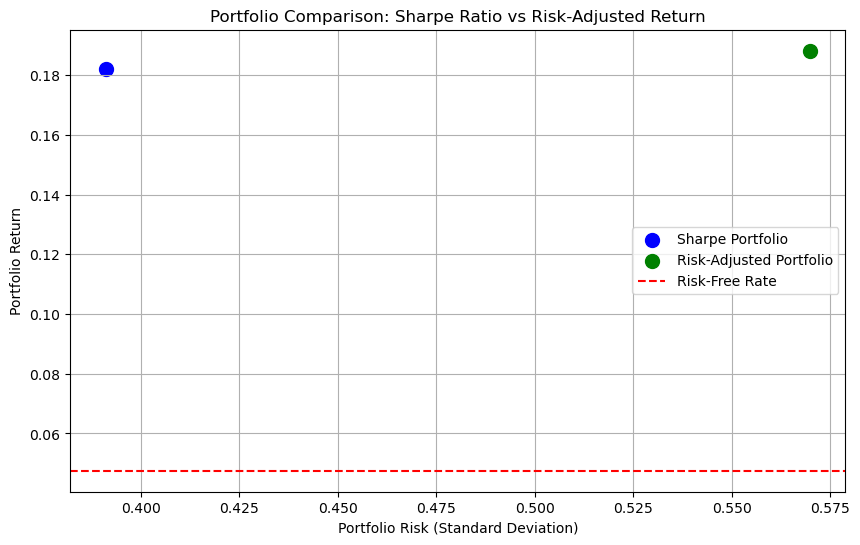

In [16]:
# Plot 1: Portfolio Comparison
plt.figure(figsize=(10, 6))
plt.scatter(optimal_std, optimal_return, color='blue', label='Sharpe Portfolio', s=100)
plt.scatter(optimal_std_rrp, optimal_return_rrp, color='green', label='Risk-Adjusted Portfolio', s=100)
plt.title("Portfolio Comparison: Sharpe Ratio vs Risk-Adjusted Return")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")
plt.axhline(y=rf, color='red', linestyle='--', label="Risk-Free Rate")
plt.legend()
plt.grid()
plt.show()

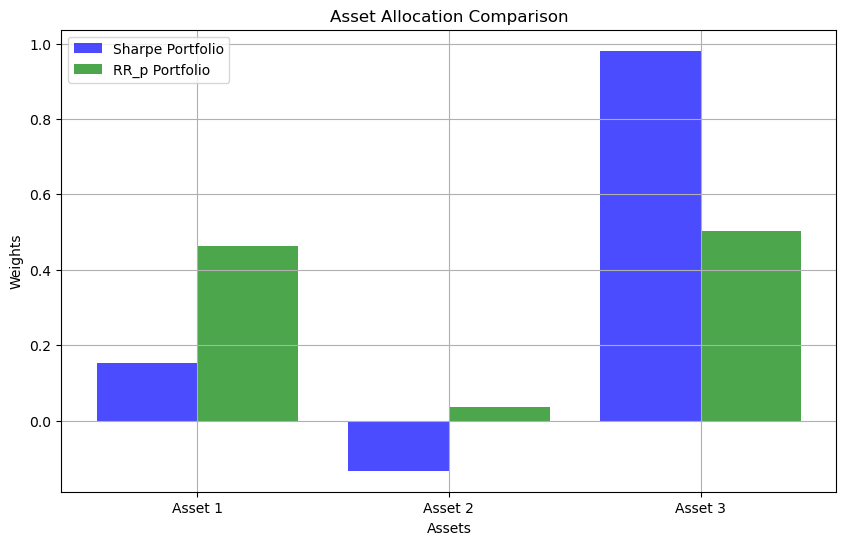

In [17]:
# Plot 2: Weights Comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(optimal_weights))  
plt.bar(x - 0.2, optimal_weights, width=0.4, label="Sharpe Portfolio", color='blue', alpha=0.7)
plt.bar(x + 0.2, optimal_weights_rrp, width=0.4, label="RR_p Portfolio", color='green', alpha=0.7)
plt.title("Asset Allocation Comparison")
plt.xlabel("Assets")
plt.ylabel("Weights")
plt.xticks(x, [f"Asset {i+1}" for i in range(len(optimal_weights))])
plt.legend()
plt.grid()
plt.show()